In [1]:
!pip install pennylane

# Turning quantum nodes into Torch Layers

Creating neural networks in [PyTorch](https://pytorch.org/) is easy
using the [nn module](https://pytorch.org/docs/stable/nn.html). Models
are constructed from elementary *layers* and can be trained using the
PyTorch API. For example, the following code defines a two-layer network
that could be used for binary classification:


In [2]:
import torch

layer_1 = torch.nn.Linear(2, 2)
layer_2 = torch.nn.Linear(2, 2)
softmax = torch.nn.Softmax(dim=1)

layers = [layer_1, layer_2, softmax]
model = torch.nn.Sequential(*layers)

In [3]:
model

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Linear(in_features=2, out_features=2, bias=True)
  (2): Softmax(dim=1)
)

**What if we want to add a quantum layer to our model?** This is
possible in PennyLane:
`QNodes` can be converted into `torch.nn` layers and combined with the wide range
of built-in classical [layers](https://pytorch.org/docs/stable/nn.html)
to create truly hybrid models. This tutorial will guide you through a
simple example to show you how it\'s done!

# Fixing the dataset and problem

Let us begin by choosing a simple dataset and problem to allow us to
focus on how the hybrid model is constructed. Our objective is to
classify points generated from scikit-learn\'s binary-class
[make_moons()](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html)
dataset:


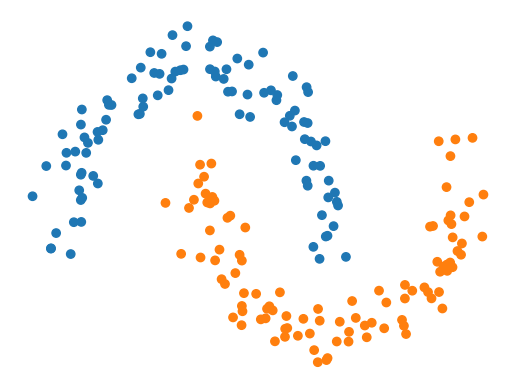

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

X, y = make_moons(n_samples=200, noise=0.1)
y_ = torch.unsqueeze(torch.tensor(y), 1)  # used for one-hot encoded labels
y_hot = torch.scatter(torch.zeros((200, 2)), 1, y_, 1)

c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y]  # colours for each class
plt.axis("off")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

In [5]:
X.mean()

0.38516313983156125

In [6]:
y, y_hot

(array([0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
        1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
        1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
        1, 1]),
 tensor([[1., 0.],
         [1., 0.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [1., 0.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [1., 

# Defining a QNode

Our next step is to define the QNode that we want to interface with
`torch.nn`. Any combination of device, operations and measurements that is valid in PennyLane can be used to compose the QNode. However, the QNode arguments must satisfy additional conditions including having an argument called `inputs`. All other arguments must
be arrays or tensors and are treated as trainable weights in the model.
We fix a two-qubit QNode using the
`default.qubit` simulator and operations from the
`templates`
module.


In [7]:
import pennylane as qml

n_qubits = 2
dev = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs * torch.pi, wires=range(n_qubits), rotation="X")
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

# Interfacing with Torch

With the QNode defined, we are ready to interface with `torch.nn`. This
is achieved using the `pennylane.qnn.TorchLayer` class of the `pennylane.qnn` module, which converts the QNode to the elementary building
block of `torch.nn`: a *layer*. We shall see in the following how the
resultant layer can be combined with other well-known neural network
layers to form a hybrid model.

We must first define the `weight_shapes` dictionary. Recall that all of
the arguments of the QNode (except the one named `inputs`) are treated
as trainable weights. For the QNode to be successfully converted to a
layer in `torch.nn`, we need to provide the details of the shape of each
trainable weight for them to be initialized. The `weight_shapes`
dictionary maps from the argument names of the QNode to corresponding
shapes:


In [8]:
n_layers = 4
weight_shapes = {"weights": (n_layers, n_qubits)}

In [9]:
weight_shapes

{'weights': (4, 2)}

In our example, the `weights` argument of the QNode is trainable and has
shape given by `(n_layers, n_qubits)`, which is passed to
`pennylane.templates.layers.BasicEntanglerLayers`.

Now that `weight_shapes` is defined, it is easy to then convert the
QNode:


In [10]:
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

In [11]:
next(qlayer.parameters()).shape

torch.Size([4, 2])

With this done, the QNode can now be treated just like any other
`torch.nn` layer and we can proceed using the familiar Torch workflow.

# Creating a hybrid model

Let\'s create a basic three-layered hybrid model consisting of:

1.  a 2-neuron fully connected classical layer
2.  our 2-qubit QNode converted into a layer
3.  another 2-neuron fully connected classical layer
4.  a softmax activation to convert to a probability vector

A diagram of the model can be seen in the figure below.

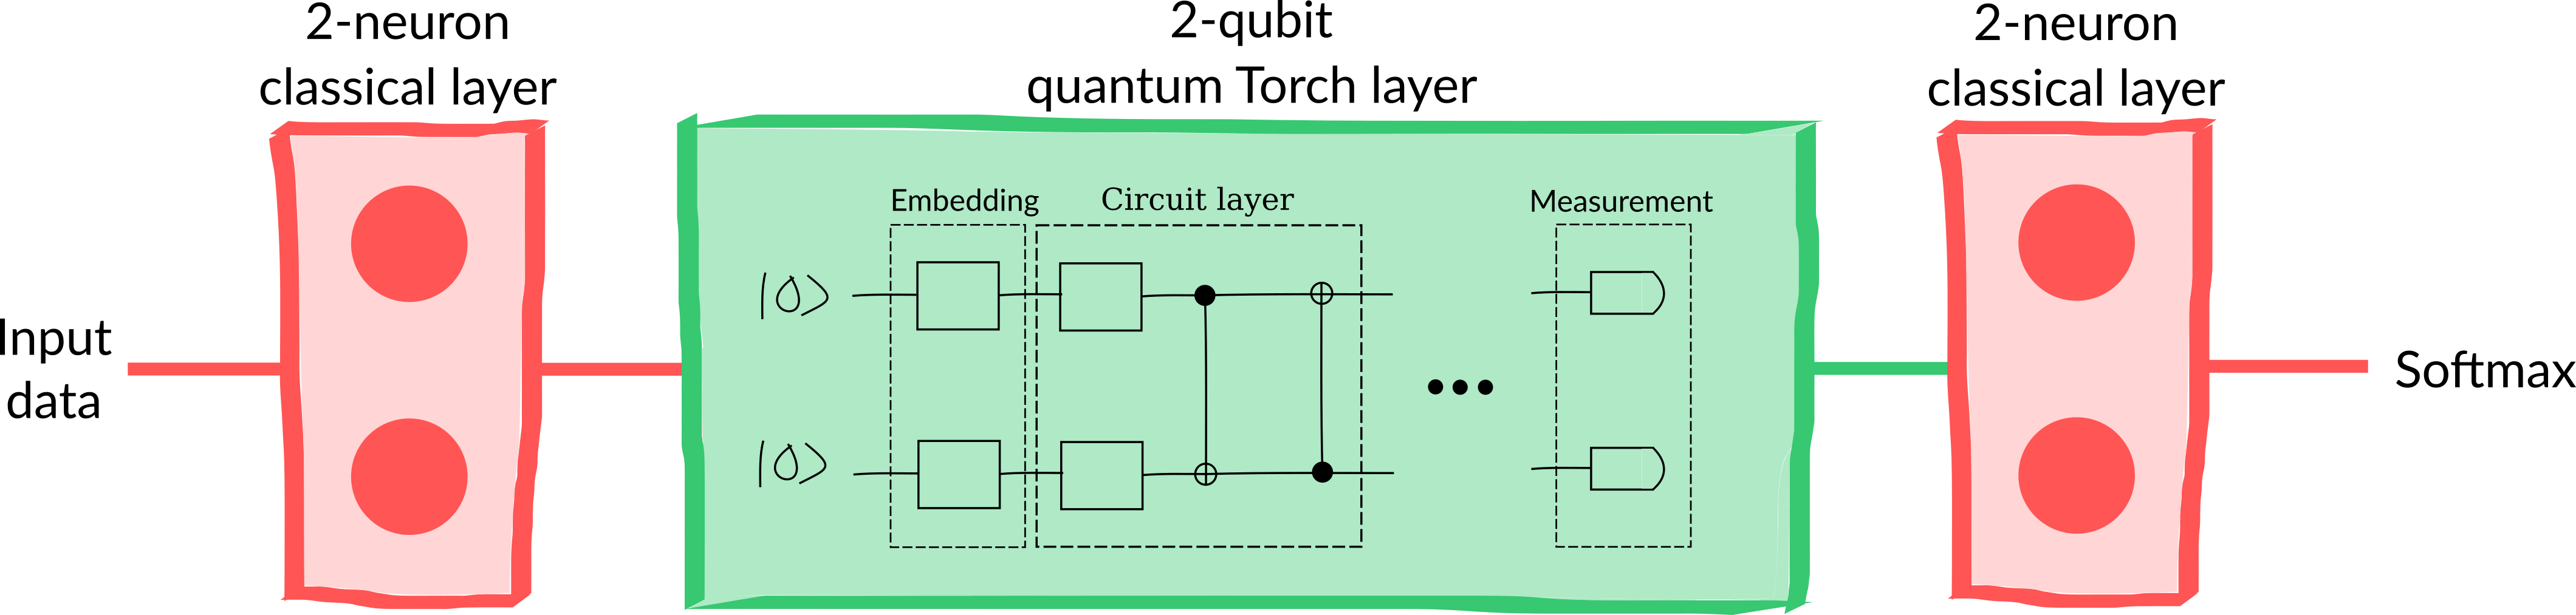

We can construct the model using the
[Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
API:


In [15]:
clayer_1 = torch.nn.Linear(2, 2)
clayer_2 = torch.nn.Linear(2, 2)
softmax = torch.nn.Softmax(dim=1)
layers = [clayer_1, qlayer, clayer_2, softmax]
model = torch.nn.Sequential(*layers)

In [16]:
model(torch.randn(5, 2))

tensor([[0.3403, 0.6597],
        [0.4140, 0.5860],
        [0.4493, 0.5507],
        [0.4742, 0.5258],
        [0.4380, 0.5620]], grad_fn=<SoftmaxBackward0>)

# Training the model

We can now train our hybrid model on the classification dataset using
the usual Torch approach. We\'ll use the standard
[SGD](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)
optimizer and the mean absolute error loss function:


In [17]:
opt = torch.optim.SGD(model.parameters(), lr=0.1)
loss = torch.nn.L1Loss()

Note that there are more advanced combinations of optimizer and loss
function, but here we are focusing on the basics.

The model is now ready to be trained!


In [18]:
X = torch.tensor(X, requires_grad=True).float()
y_hot = y_hot.float()

batch_size = 5
batches = 200 // batch_size

data_loader = torch.utils.data.DataLoader(
    list(zip(X, y_hot)), batch_size=5, shuffle=True, drop_last=True
)

epochs = 30

for epoch in range(epochs):

    running_loss = 0

    for xs, ys in data_loader:
        opt.zero_grad()

        loss_evaluated = loss(model(xs), ys)
        loss_evaluated.backward()

        opt.step()

        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

y_pred = model(X)
predictions = torch.argmax(y_pred, axis=1).detach().numpy()

correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y)]
accuracy = sum(correct) / len(correct)
print(f"Accuracy: {accuracy * 100}%")

Average loss over epoch 1: 0.4209
Average loss over epoch 2: 0.2660
Average loss over epoch 3: 0.2049
Average loss over epoch 4: 0.1843
Average loss over epoch 5: 0.1712
Average loss over epoch 6: 0.1671
Average loss over epoch 7: 0.1672
Average loss over epoch 8: 0.1614
Average loss over epoch 9: 0.1595
Average loss over epoch 10: 0.1598
Average loss over epoch 11: 0.1519
Average loss over epoch 12: 0.1563
Average loss over epoch 13: 0.1597
Average loss over epoch 14: 0.1585
Average loss over epoch 15: 0.1635
Average loss over epoch 16: 0.1434
Average loss over epoch 17: 0.1527
Average loss over epoch 18: 0.1525
Average loss over epoch 19: 0.1571
Average loss over epoch 20: 0.1638
Average loss over epoch 21: 0.1622
Average loss over epoch 22: 0.1541
Average loss over epoch 23: 0.1535
Average loss over epoch 24: 0.1538
Average loss over epoch 25: 0.1508
Average loss over epoch 26: 0.1342
Average loss over epoch 27: 0.1441
Average loss over epoch 28: 0.1461
Average loss over epoch 29: 0

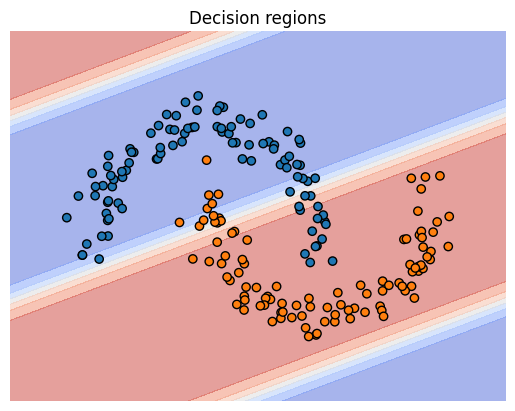

In [19]:
# Plot decision boundaries
# Generate a grid of points
xx, yy = np.meshgrid(np.linspace(X[:, 0].detach().numpy().min()-0.5, X[:, 0].detach().numpy().max()+0.5, 100),
                     np.linspace(X[:, 1].detach().numpy().min()-0.5, X[:, 1].detach().numpy().max()+0.5, 100))
grid = np.c_[xx.ravel(), yy.ravel()]

# Convert grid to tensor and pass through the model
grid_tensor = torch.tensor(grid, dtype=torch.float)
with torch.no_grad():
    grid_predictions = model(grid_tensor)
    Z = grid_predictions[:, 1].numpy().reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.coolwarm)
plt.scatter(X[:, 0].detach().numpy(), X[:, 1].detach().numpy(), c=c, edgecolor='k')
plt.title("Decision regions")
plt.axis("off")
plt.show()

torch.Size([10000, 2])


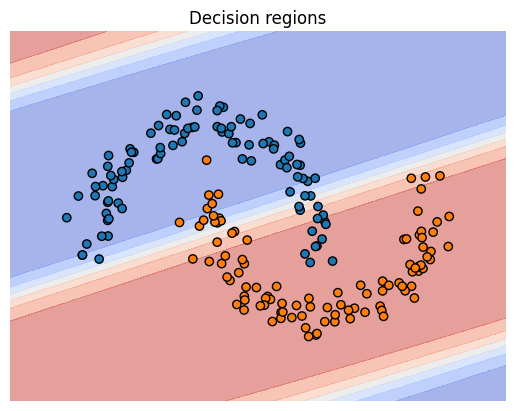

In [ ]:
# Plot decision boundaries
# Generate a grid of points
xx, yy = np.meshgrid(np.linspace(X[:, 0].detach().numpy().min()-0.5, X[:, 0].detach().numpy().max()+0.5, 100),
                     np.linspace(X[:, 1].detach().numpy().min()-0.5, X[:, 1].detach().numpy().max()+0.5, 100))
grid = np.c_[xx.ravel(), yy.ravel()]

# Convert grid to tensor and pass through the model
grid_tensor = torch.tensor(grid, dtype=torch.float)
with torch.no_grad():
    grid_predictions = model(grid_tensor)
    Z = grid_predictions[:, 1].numpy().reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.coolwarm)
plt.scatter(X[:, 0].detach().numpy(), X[:, 1].detach().numpy(), c=c, edgecolor='k')
plt.title("Decision regions")
plt.axis("off")
plt.show()

How did we do? The model looks to have successfully trained and the
accuracy is reasonably high. In practice, we would aim to push the
accuracy higher by thinking carefully about the model design and the
choice of hyperparameters such as the learning rate.

# Creating non-sequential models

The model we created above was composed of a sequence of classical and
quantum layers. This type of model is very common and is suitable in a
lot of situations. However, in some cases we may want a greater degree
of control over how the model is constructed, for example when we have
multiple inputs and outputs or when we want to distribute the output of
one layer into multiple subsequent layers.

Suppose we want to make a hybrid model consisting of:

1.  a 4-neuron fully connected classical layer
2.  a 2-qubit quantum layer connected to the first two neurons of the
    previous classical layer
3.  a 2-qubit quantum layer connected to the second two neurons of the
    previous classical layer
4.  a 2-neuron fully connected classical layer which takes a
    4-dimensional input from the combination of the previous quantum
    layers
5.  a softmax activation to convert to a probability vector

A diagram of the model can be seen in the figure below.

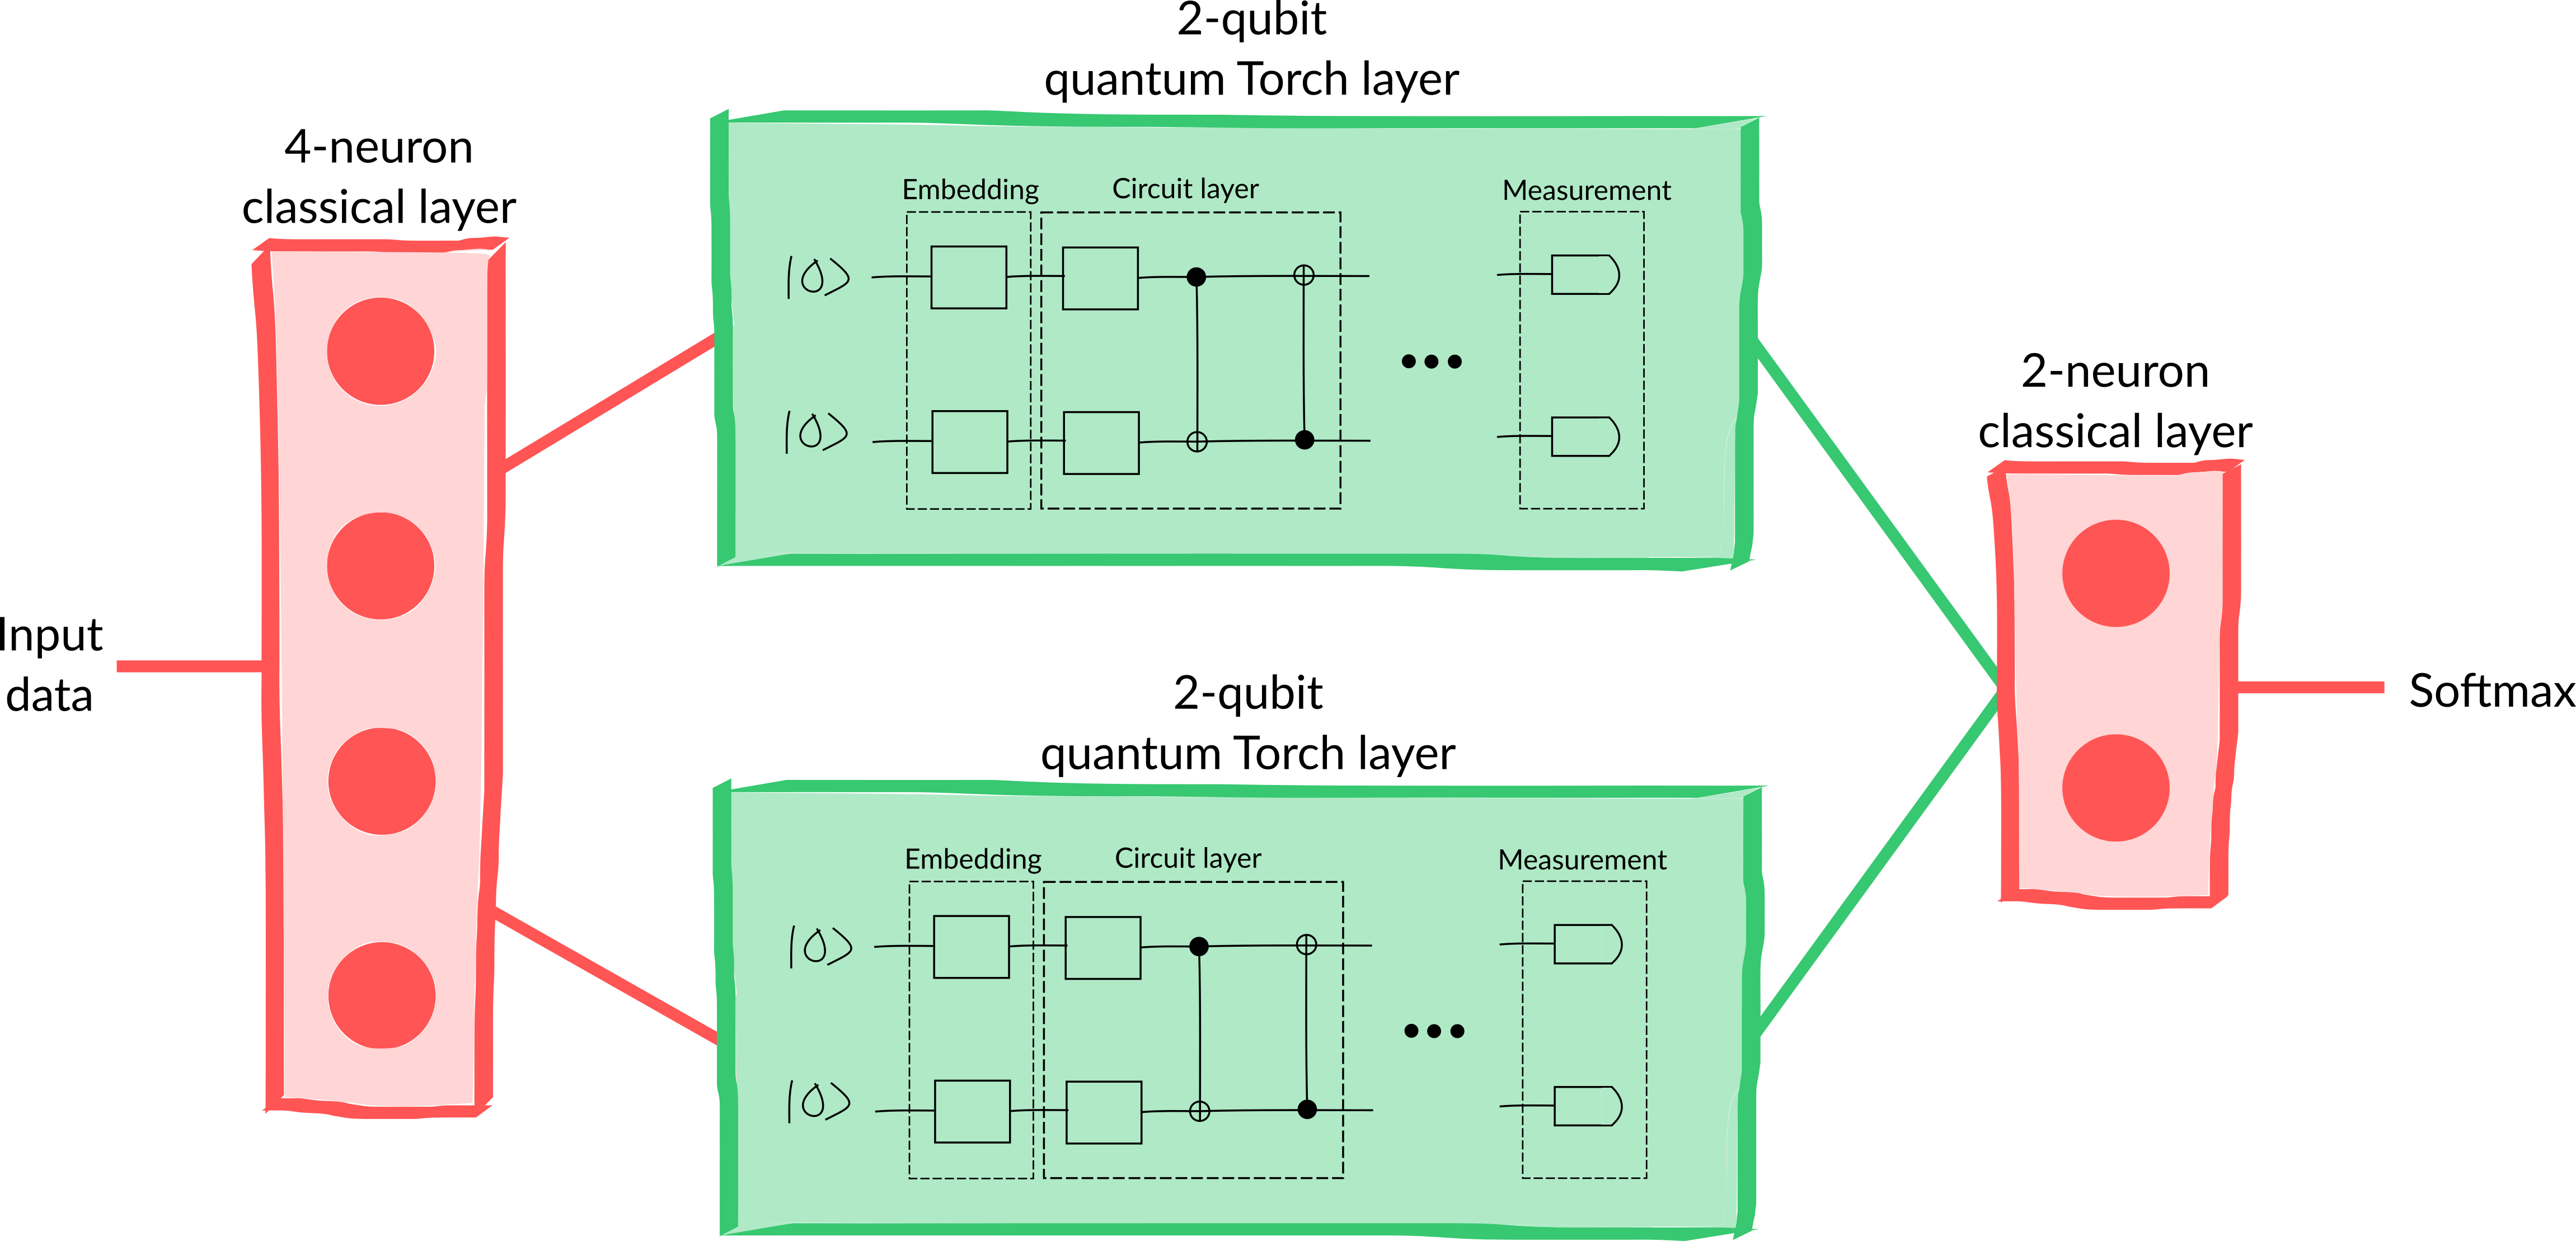

This model can also be constructed by creating a new class that inherits
from the `torch.nn`
[Module](https://pytorch.org/docs/stable/nn.html#torch.nn.Module) and
overriding the `forward()` method:


In [20]:
class HybridModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.clayer_1 = torch.nn.Linear(2, 4)
        self.qlayer_1 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.qlayer_2 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.clayer_2 = torch.nn.Linear(4, 2)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.clayer_1(x)
        x_1, x_2 = torch.split(x, 2, dim=1)
        x_1 = self.qlayer_1(x_1)
        x_2 = self.qlayer_2(x_2)
        x = torch.cat([x_1, x_2], axis=1)
        x = self.clayer_2(x)
        return self.softmax(x)

model = HybridModel()

In [21]:
model

HybridModel(
  (clayer_1): Linear(in_features=2, out_features=4, bias=True)
  (qlayer_1): <Quantum Torch Layer: func=qnode>
  (qlayer_2): <Quantum Torch Layer: func=qnode>
  (clayer_2): Linear(in_features=4, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

As a final step, let\'s train the model to check if it\'s working:


In [22]:
opt = torch.optim.SGD(model.parameters(), lr=0.2)
epochs = 6

for epoch in range(epochs):

    running_loss = 0

    for xs, ys in data_loader:
        opt.zero_grad()

        loss_evaluated = loss(model(xs), ys)
        loss_evaluated.backward()

        opt.step()

        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

y_pred = model(X)
predictions = torch.argmax(y_pred, axis=1).detach().numpy()

correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y)]
accuracy = sum(correct) / len(correct)
print(f"Accuracy: {accuracy * 100}%")

Average loss over epoch 1: 0.3606
Average loss over epoch 2: 0.1952
Average loss over epoch 3: 0.1654
Average loss over epoch 4: 0.1622
Average loss over epoch 5: 0.1588
Average loss over epoch 6: 0.1765
Accuracy: 87.0%


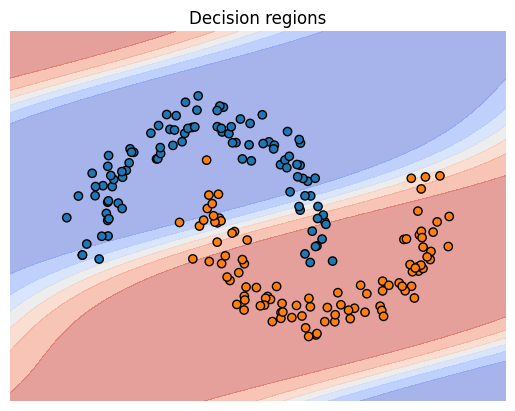

In [23]:
# Plot decision boundaries
# Generate a grid of points
xx, yy = np.meshgrid(np.linspace(X[:, 0].detach().numpy().min()-0.5, X[:, 0].detach().numpy().max()+0.5, 100),
                     np.linspace(X[:, 1].detach().numpy().min()-0.5, X[:, 1].detach().numpy().max()+0.5, 100))
grid = np.c_[xx.ravel(), yy.ravel()]

# Convert grid to tensor and pass through the model
grid_tensor = torch.tensor(grid, dtype=torch.float)
with torch.no_grad():
    grid_predictions = model(grid_tensor)
    Z = grid_predictions[:, 1].numpy().reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.coolwarm)
plt.scatter(X[:, 0].detach().numpy(), X[:, 1].detach().numpy(), c=c, edgecolor='k')
plt.title("Decision regions")
plt.axis("off")
plt.show()

## Another way of building Quantum layer

We can use class that inherits from `torch.nn.Module`. Like this:

In [49]:
class MyQuantumLayer(torch.nn.Module):
    rotations = {
        "X": qml.RX,
        "Y": qml.RY,
        "Z": qml.RZ,
    }

    measurements = {
        "X": qml.PauliX,
        "Y": qml.PauliY,
        "Z": qml.PauliZ,
    }

    def __init__(self, in_features, n_qubits, depth, embedding="X", rotation="Y", measurement="Z", device="lightning.qubit"):
        # in_features, depth, n_qubits, embedding(X), rotation (Y), measurement (Z), device (lightning)
        # init hyperparameters
        # self.<...> = <...>
        super().__init__()
        self.in_features = in_features
        self.n_qubits = n_qubits
        self.depth = depth
        self.embedding = embedding
        self.rotation = rotation
        self.measurement = measurement
        self.device = device

        # check that n_qubits is divisible by in_features
        if self.in_features % self.n_qubits != 0:
            raise ValueError(f"in_features must be divisible by n_qubits, but got in_features={self.in_features} and n_qubits={self.n_qubits}")

        self.parallel_circuits = self.in_features // self.n_qubits

        # init device
        self.dev = qml.device(self.device, shots=None, wires=self.n_qubits)

        # init weights
        self.weights = torch.nn.Parameter(torch.empty(self.parallel_circuits, self.depth, self.n_qubits))
        self.reset_weights()

        # init QNode
        self.qnode = qml.QNode(self.circuit, self.dev, interface="torch", diff_method="best")


    def circuit(self, inputs, weights):
        # inputs -> (batch_size, n_qubits)
        for i in range(self.n_qubits):
            self.rotations[self.embedding](inputs[..., i], wires=[i])

        for j in range(self.depth):
            for i in range(self.n_qubits):
                self.rotations[self.rotation](weights[j, i], wires=[i])

            for i in range(self.n_qubits):
                qml.CNOT(wires=[i % self.n_qubits, (i + 1) % self.n_qubits])

        return [qml.expval(self.measurements[self.measurement](wires=[i])) for i in range(self.n_qubits)]

    def forward(self, x):
        splitted = torch.split(x, self.n_qubits, dim=1)
        res = []
        for i in range(self.parallel_circuits):
            res_ = self.qnode(splitted[i], self.weights[i])
            res_ = torch.stack(res_).T
            res.append(res_)

        res = torch.cat(res, dim=-1)

        return res

    def extra_repr(self):
        return (f"in_features={self.in_features}, n_qubits={self.n_qubits}, depth={self.depth}, "
                f"embedding='{self.embedding}', rotation='{self.rotation}', measurement='{self.measurement}', "
                f"device='{self.device}'")

    # def __repr__(self):
    #     return "ABC"

    def reset_weights(self):
        torch.nn.init.uniform_(self.weights, a=0, b=2 * torch.pi)

    def draw_circuit(self):
        sample_input = torch.randn((self.n_qubits,))

        circuit_drawer = qml.draw(self.qnode)
        circuit_diagram = circuit_drawer(sample_input, self.weights[0])

        print(circuit_diagram)

    def draw_circuit_mpl(self):
        # Generate a sample input and weights for visualization
        sample_input = torch.randn((self.n_qubits,))

        # Use qml.draw_mpl to plot the circuit
        qml.draw_mpl(self.qnode)(sample_input, self.weights[0])
        plt.title("Quantum Circuit")
        plt.show()

In [50]:
test = MyQuantumLayer(6, 3, 4)

In [51]:
test

MyQuantumLayer(in_features=6, n_qubits=3, depth=4, embedding='X', rotation='Y', measurement='Z', device='lightning.qubit')

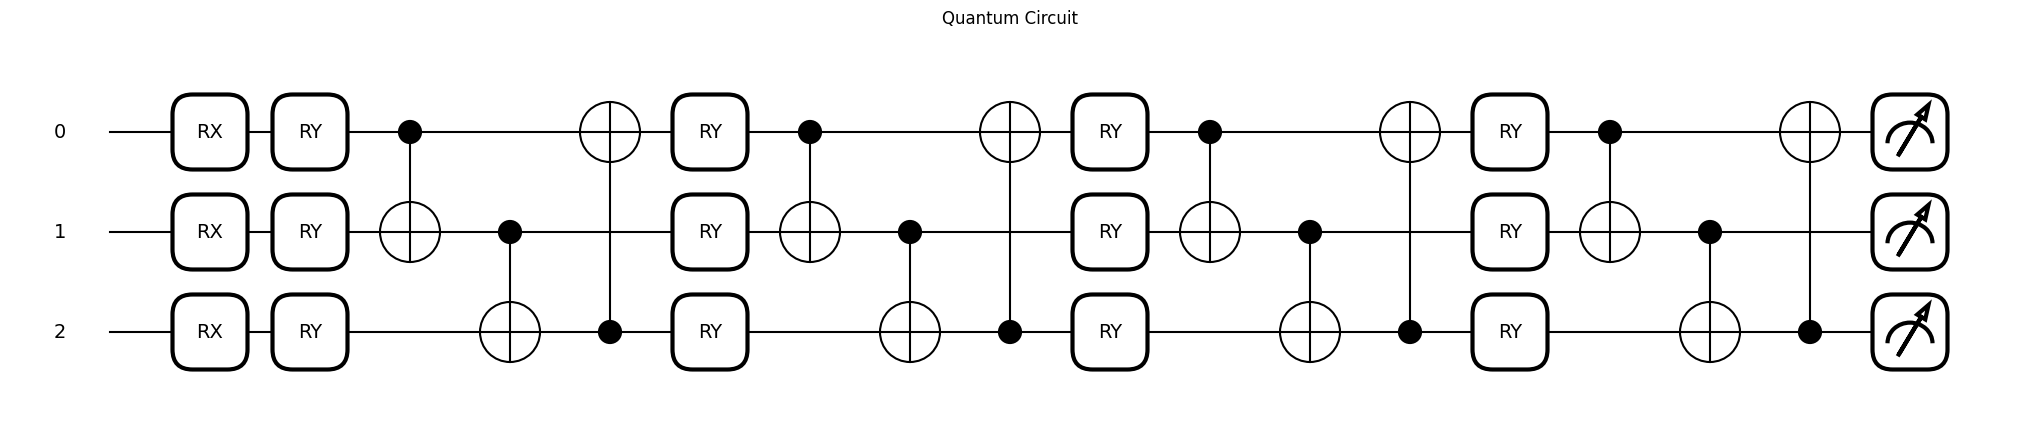

In [52]:
test.draw_circuit_mpl()

In [66]:
class HybridModelEnhanced(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.clayer_1 = torch.nn.Linear(2, 4)
        self.qlayer = MyQuantumLayer(4, 2, 3)
        self.clayer_2 = torch.nn.Linear(4, 2)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.clayer_1(x)
        x = self.qlayer(x)
        x = self.clayer_2(x)
        return x

model = HybridModelEnhanced()

In [67]:
model

HybridModelEnhanced(
  (clayer_1): Linear(in_features=2, out_features=4, bias=True)
  (qlayer): MyQuantumLayer(in_features=4, n_qubits=2, depth=3, embedding='X', rotation='Y', measurement='Z', device='lightning.qubit')
  (clayer_2): Linear(in_features=4, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

In [68]:
opt = torch.optim.Adam(model.parameters(), lr=0.1, betas=(0.9, 0.99))
loss = torch.nn.CrossEntropyLoss()
epochs = 20

for epoch in range(epochs):

    running_loss = 0

    for xs, ys in data_loader:
        opt.zero_grad()

        loss_evaluated = loss(model(xs), ys)
        loss_evaluated.backward()

        opt.step()

        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

y_pred = model(X)
predictions = torch.argmax(y_pred, axis=1).detach().numpy()

correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y)]
accuracy = sum(correct) / len(correct)
print(f"Accuracy: {accuracy * 100}%")

Average loss over epoch 1: 0.3658
Average loss over epoch 2: 0.3355
Average loss over epoch 3: 0.1938
Average loss over epoch 4: 0.0638
Average loss over epoch 5: 0.0362
Average loss over epoch 6: 0.0754
Average loss over epoch 7: 0.0241
Average loss over epoch 8: 0.0796
Average loss over epoch 9: 0.0522
Average loss over epoch 10: 0.0463
Average loss over epoch 11: 0.0286
Average loss over epoch 12: 0.0609
Average loss over epoch 13: 0.0229
Average loss over epoch 14: 0.0315
Average loss over epoch 15: 0.0265
Average loss over epoch 16: 0.1269
Average loss over epoch 17: 0.0420
Average loss over epoch 18: 0.0209
Average loss over epoch 19: 0.0272
Average loss over epoch 20: 0.0250
Accuracy: 99.5%


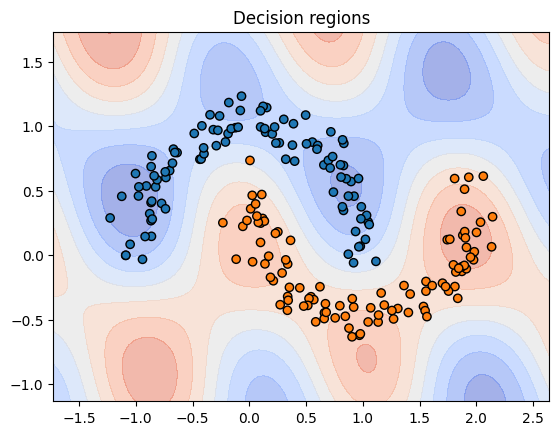

In [69]:
# Plot decision boundaries
# Generate a grid of points
xx, yy = np.meshgrid(np.linspace(X[:, 0].detach().numpy().min()-0.5, X[:, 0].detach().numpy().max()+0.5, 100),
                     np.linspace(X[:, 1].detach().numpy().min()-0.5, X[:, 1].detach().numpy().max()+0.5, 100))
grid = np.c_[xx.ravel(), yy.ravel()]

# Convert grid to tensor and pass through the model
grid_tensor = torch.tensor(grid, dtype=torch.float)
with torch.no_grad():
    grid_predictions = model(grid_tensor)
    Z = grid_predictions[:, 1].numpy().reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.coolwarm)
plt.scatter(X[:, 0].detach().numpy(), X[:, 1].detach().numpy(), c=c, edgecolor='k')
plt.title("Decision regions")
# plt.axis("off")
plt.show()

In [ ]:
class MyQuantumLayer(torch.nn.Module):
    rotations = {
        "X": qml.RX,
        "Y": qml.RY,
        "Z": qml.RZ,
    }

    measurements = {
        "X": qml.PauliX,
        "Y": qml.PauliY,
        "Z": qml.PauliZ,
    }

    def __init__(
            self,
            in_features,
            n_qubits,
            depth,
            embedding="X",
            rotation="Y",
            measurement="Z",
            device="lightning.qubit"
            ):
        super().__init__()
        self.in_features = in_features
        self.n_qubits = n_qubits
        self.depth = depth
        self.embedding = embedding
        self.rotation = rotation
        self.measurement = measurement
        self.device = device

        if self.in_features % self.n_qubits != 0:
            raise ValueError(f"in_features must be divisible by n_qubits, but got self.in_features={self.in_features} and self.n_qubits={self.n_qubits}")

        self.parallel_circuits = self.in_features // self.n_qubits

        self.dev = qml.device(self.device, wires=self.n_qubits, shots=None)

        self.weights = torch.nn.Parameter(torch.empty(self.parallel_circuits, self.depth, self.n_qubits))
        self.reset_weights()

        self.qnode = qml.QNode(self.circuit, self.dev, interface="torch", diff_method="best")


    def circuit(self, inputs, weights):
        for i in range(self.n_qubits):
            self.rotations[self.embedding](inputs[..., i], wires=[i])

        for i in range(self.depth):
            for j in range(self.n_qubits):
                self.rotations[self.rotation](weights[i, j], wires=[j])

            for j in range(self.n_qubits):
                qml.CNOT(wires=[j % self.n_qubits, (j + 1) % self.n_qubits])

        return [qml.expval(self.measurements[self.measurement](wires=i)) for i in range(self.n_qubits)]


    def forward(self, x):
        splitted = torch.split(x, self.n_qubits, dim=1)
        res = []
        for i in range(self.parallel_circuits):
            res_ = self.qnode(splitted[i], self.weights[i])
            res_ = torch.stack(res_).T
            res.append(res_)

        res = torch.cat(res, dim=-1)

        return res

    def reset_weights(self):
        torch.nn.init.uniform_(self.weights, a=0, b=2 * torch.pi)

    def draw_circuit(self):
        sample_input = torch.randn((self.n_qubits,))

        circuit_drawer = qml.draw(self.qnode)
        circuit_diagram = circuit_drawer(sample_input, self.weights[0])

        print(circuit_diagram)

    def draw_circuit_mpl(self):
        # Generate a sample input and weights for visualization
        sample_input = torch.randn((self.n_qubits,))

        # Use qml.draw_mpl to plot the circuit
        qml.draw_mpl(self.qnode)(sample_input, self.weights[0])
        plt.title("Quantum Circuit")
        plt.show()


    def extra_repr(self):
        return (f"in_features={self.in_features}, n_qubits={self.n_qubits}, depth={self.depth}, "
                f"embedding='{self.embedding}', rotation='{self.rotation}', measurement='{self.measurement}', "
                f"device='{self.device}'")

In [ ]:
test = MyQuantumLayer(6, 3, 2)

In [ ]:
test.draw_circuit()

0: ──RX(1.11)──RY(4.98)─╭●────╭X──RY(1.21)─╭●────╭X─┤  <Z>
1: ──RX(0.34)──RY(0.63)─╰X─╭●─│───RY(2.64)─╰X─╭●─│──┤  <Z>
2: ──RX(0.51)──RY(3.15)────╰X─╰●──RY(0.64)────╰X─╰●─┤  <Z>


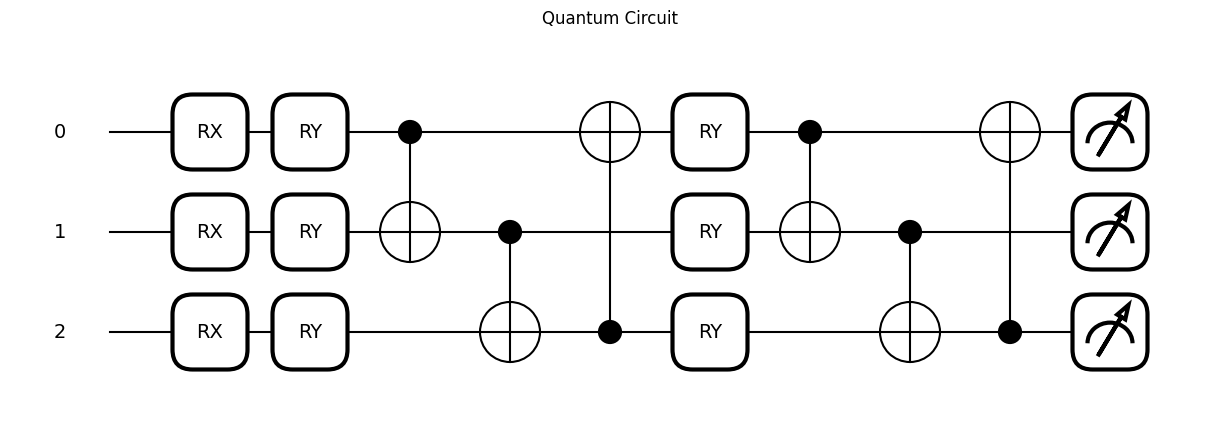

In [ ]:
test.draw_circuit_mpl()